<a href="https://colab.research.google.com/github/NicolasPham/DataAnalystProjects/blob/main/CarPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goal of Project:
This is the project to create a prediction of **used car price** base on their specifications like Brand, Mileage, Year, Engine Volumn, etc.
We will use pandas to preprocess and clean data before using sklearn and statsmodel to make prediction on price

#### Data Cleaning result:
- There is 3947 out of 4345 as **Yes** on registration, this variable won't be helpful
- There is 312 unique records in model so this will create over 300 dummies which will be hard to implemented. We will exclude this
- There is less 5% of missing values in column Price and Engine Volumn, we can just drop those missing values
- they are **Outliers** in ['Price', 'EngineV', 'Year', 'Mileage'], I use quantile of 1% to remove those observations

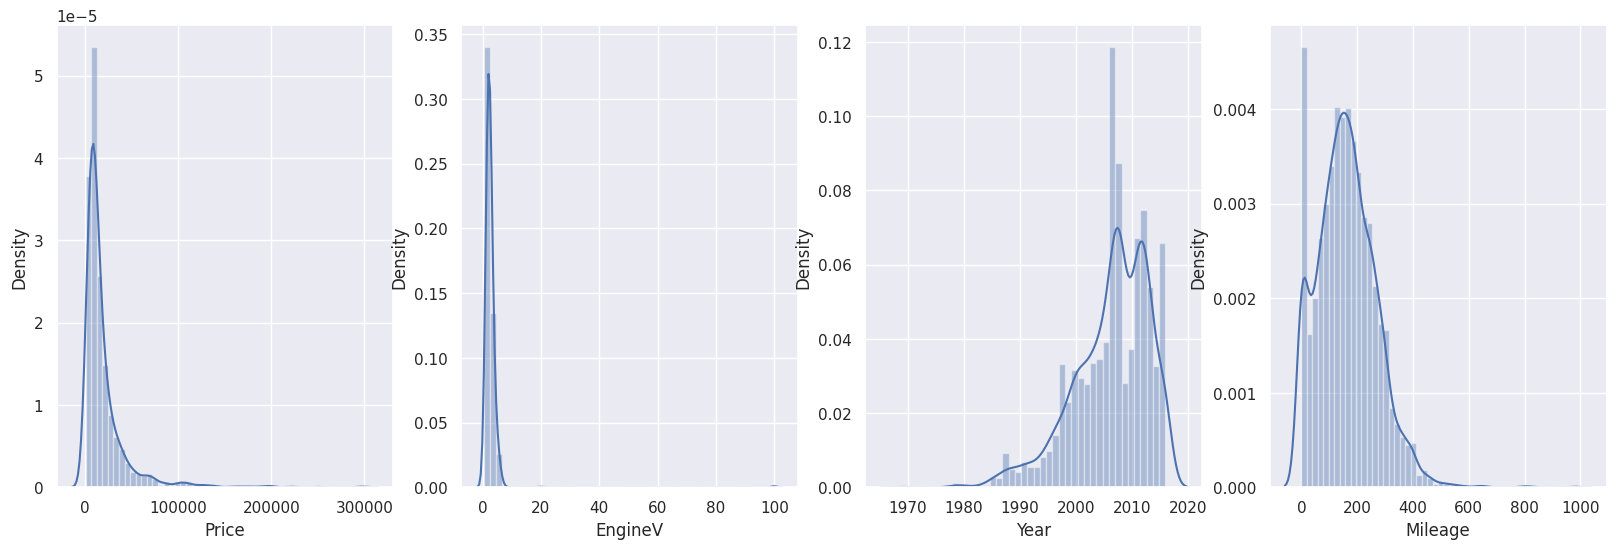

#### Check OLS Assumptions
- Relationship between "Mileage", "EngineV", "Year" to "Price" are not linear
  - Need to transform "Price" to log
- Data is Normalized
- Data is no **Autocorrelation** since data is not coming from Time Series data
- MultiCollinearity: it's logical that year and mileage are correlated. I use VIF (variance inflation factor) for checking this assumption
  - VIF = 1: No MultiCollinearity
  - 1 < VIF < 5: perfectly acceptable
  - **Year has VIF > 10**: I will not use this column for regression

#### Regression result
- Based on the Residuals PDF, there is a longer tail on the right side means the predicted values is higher than observed values
- Weights Interpretation: a positive weight shows that as a feature increase in value, so do the **logPrice** and **Price** respectively such as EngineV, Mercedes and BMW
- A positive weight show that the respective category Brand is **more expensive** than the benchmark (Audi)
- All of Body weights is negative, so the benchmark **(Crossover)** is  the most expensive body category
- **Diesel** (benchmark) is the cheapest engine type compared to others types
- After testing, we conclude that the model is **very good at predicting higher prices** due to its concentration at this area
- Based on the **"Difference %"** between target test and target prediction test, we can conclude that our model is relative close with **25%, 50%, 75% quantile**

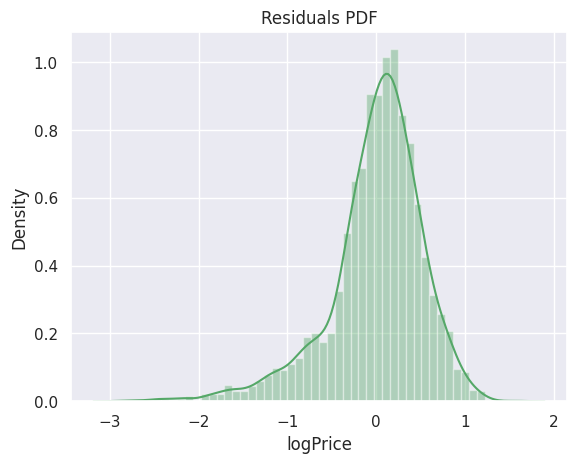

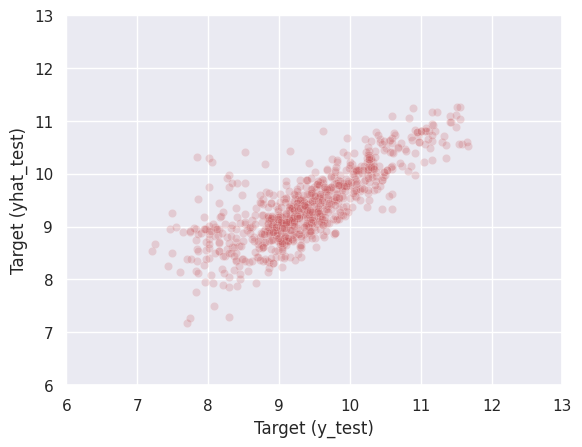

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [187]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Dataset/CarAnalysis/CarAnalysis.csv')
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [188]:
df.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [189]:
df.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [190]:
print('Before drop ' + str(df.shape[0]))
df.dropna(axis=0, inplace=True)
print('After drop ' + str(df.shape[0]))

Before drop 4345
After drop 4025


#### Looking for outliers

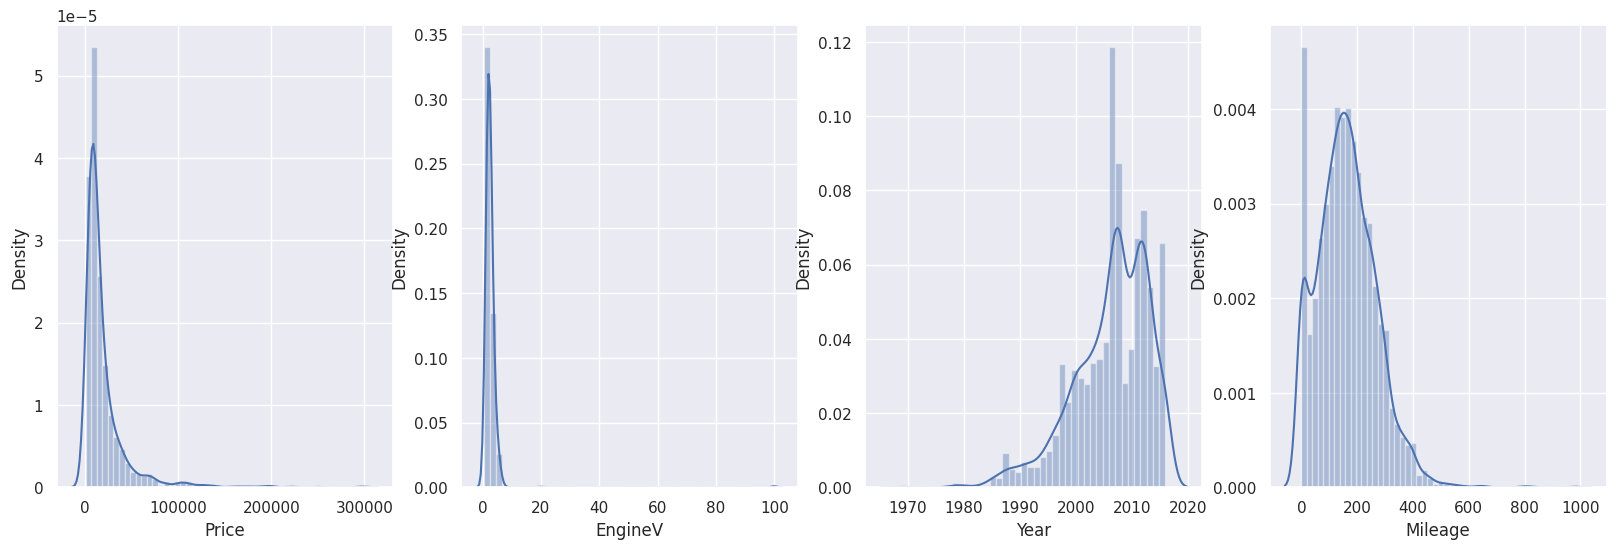

In [191]:
fig, ax = plt.subplots(1, 4, figsize=(20,6))

columns = ['Price', 'EngineV', 'Year', 'Mileage']

for index, col in enumerate(columns, 0):
  sns.distplot(df[col], ax=ax[index])
plt.show()

#### Dealing with Outliers

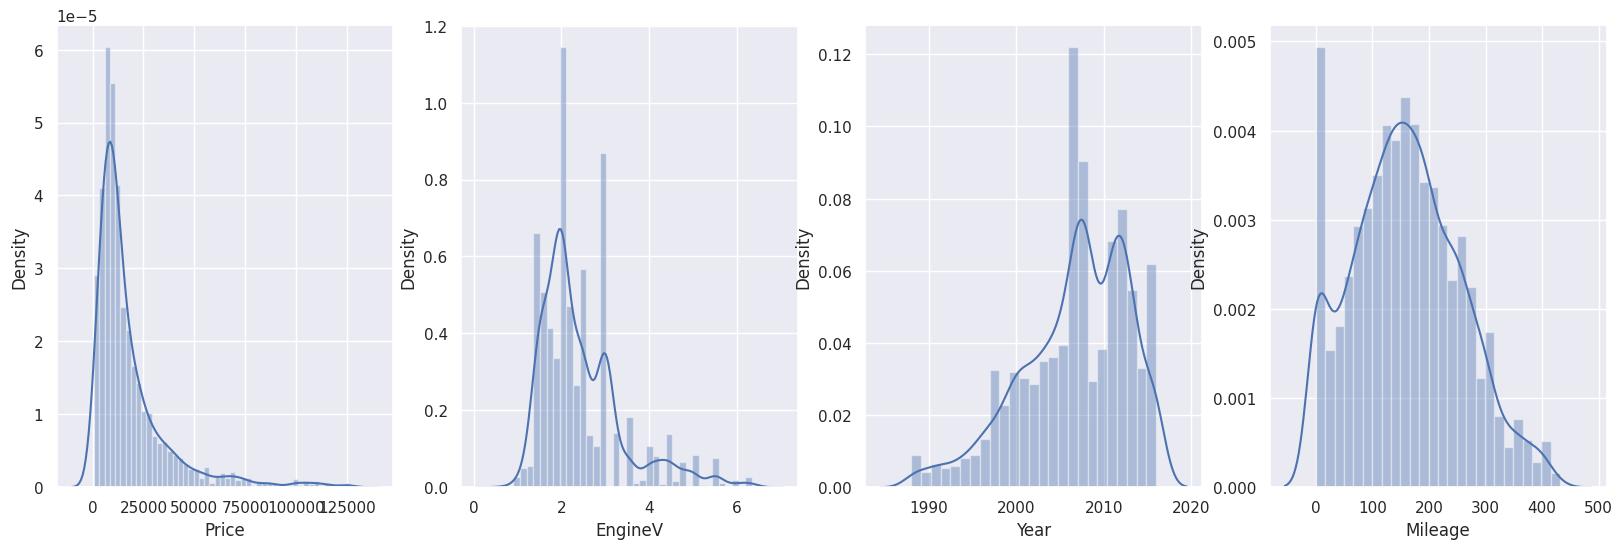

In [192]:
q1 = df['Price'].quantile(0.99)
new_df = df[df['Price'] < q1]
new_df = new_df[new_df['EngineV'] <= 6.5]

q2 = new_df['Year'].quantile(0.01)
new_df = new_df[new_df['Year'] > q2]

q3 = new_df['Mileage'].quantile(0.99)
new_df = new_df[new_df['Mileage'] < q3]

fig, ax = plt.subplots(1, 4, figsize=(20,6))

columns = ['Price', 'EngineV', 'Year', 'Mileage']

for index, col in enumerate(columns, 0):
  sns.distplot(new_df[col], ax=ax[index])
plt.show()

In [193]:
df_cleaned = new_df.reset_index(drop=True)

### Checking OLS Assumptions
#### 1. Linearity

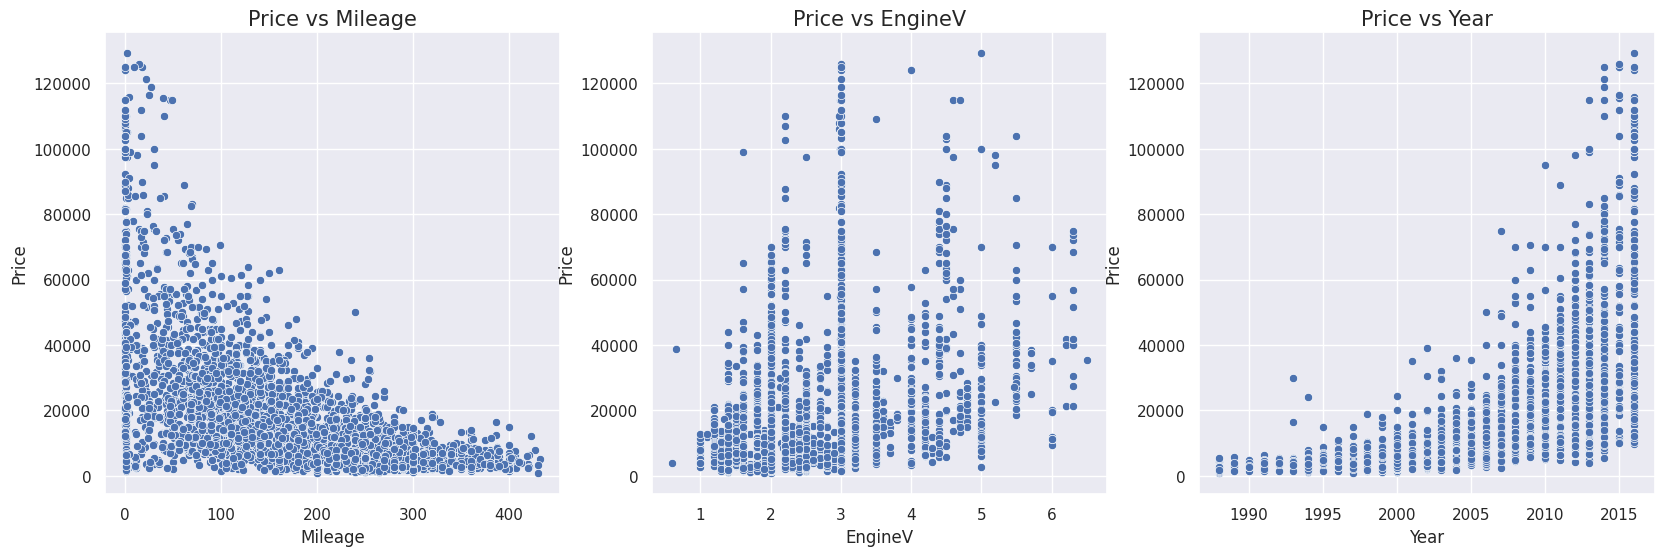

In [194]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

columns = ['Mileage', 'EngineV', 'Year']
for index, col in enumerate(columns, 0):
  sns.scatterplot(data = df_cleaned, x = df_cleaned[col], y = df_cleaned['Price'], ax=ax[index])
  ax[index].set_title('Price vs ' + col, fontsize=15, pad=5)

plt.show()

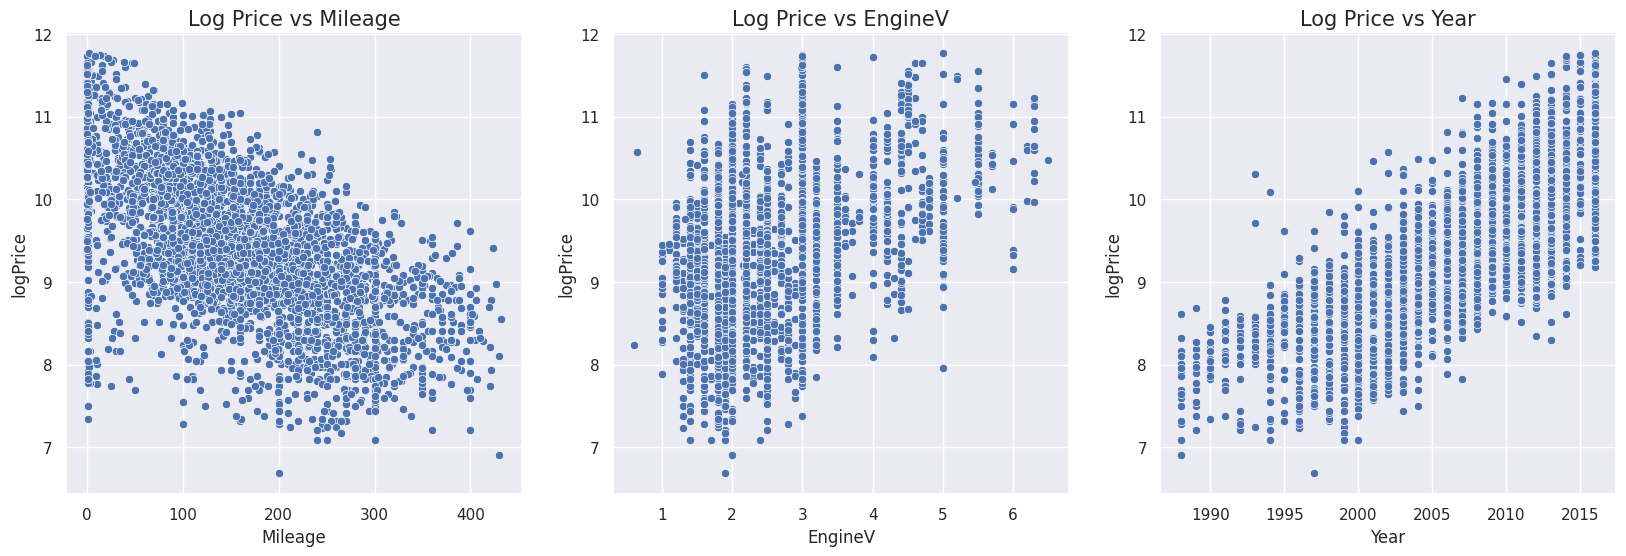

In [195]:
df_cleaned['logPrice'] = np.log(df_cleaned['Price'])

fig, ax = plt.subplots(1,3, figsize=(20,6))

columns = ['Mileage', 'EngineV', 'Year']

for index, col in enumerate(columns, 0):
  sns.scatterplot(data = df_cleaned, x = df_cleaned[col], y = df_cleaned['logPrice'], ax=ax[index])
  ax[index].set_title('Log Price vs ' + col, fontsize=15, pad=5)

plt.show()

#### 2. MultiCollinearity

In [196]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [197]:
variables = df_cleaned[['Year', 'Mileage', 'EngineV']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns

vif

,VIF,Features
0,10.338952,Year
1,3.797770,Mileage
2,7.634900,EngineV


In [198]:
df_cleaned.drop(['Year'], axis=1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Model,logPrice
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,Rav 4,9.814656
...,...,...,...,...,...,...,...,...,...
3861,Volkswagen,11500.0,van,163,2.5,Diesel,yes,T5 (Transporter),9.350102
3862,Toyota,17900.0,sedan,35,1.6,Petrol,yes,Corolla,9.792556
3863,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,S 350,11.736069
3864,BMW,6500.0,sedan,1,3.5,Petrol,yes,535,8.779557


### Create dummies

In [199]:
new_df = df_cleaned[['Brand', 'logPrice', 'Body', 'Mileage', 'EngineV', 'Engine Type']]

In [200]:
data_w_dummies = pd.get_dummies(new_df, drop_first = True)
data_w_dummies.head()

,logPrice,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Standardize data

In [201]:
# Define the target and inputs
target = data_w_dummies['logPrice']
input = data_w_dummies.drop(['logPrice'], axis=1)

In [202]:
# Scale the data
from sklearn.preprocessing import StandardScaler

In [203]:
scaler = StandardScaler()
scaled_input = scaler.fit(input).transform(input)

In [204]:
scaled_input

array([[ 1.22181915, -0.4743    ,  2.27936676, ..., -0.41500071,
        -0.16211373,  1.33240576],
       [ 2.79364022,  0.47155438, -0.43871834, ..., -0.41500071,
        -0.16211373, -0.75052213],
       [ 2.07060253,  2.67854794, -0.43871834, ...,  2.40963442,
        -0.16211373, -0.75052213],
       ...,
       [-1.58650116,  0.57664931, -0.43871834, ..., -0.41500071,
        -0.16211373, -0.75052213],
       [-1.67033162,  1.10212397,  2.27936676, ..., -0.41500071,
        -0.16211373,  1.33240576],
       [-0.38143834, -0.4743    , -0.43871834, ..., -0.41500071,
        -0.16211373, -0.75052213]])

In [205]:
# Train Test Split
from sklearn.model_selection import train_test_split

In [206]:
x_train, x_test, y_train, y_test = train_test_split(scaled_input, target, test_size = 0.2, shuffle=True, random_state = 163)

### Create Regression

In [207]:
from sklearn.linear_model import LinearRegression

In [208]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [209]:
yhat = reg.predict(x_train)

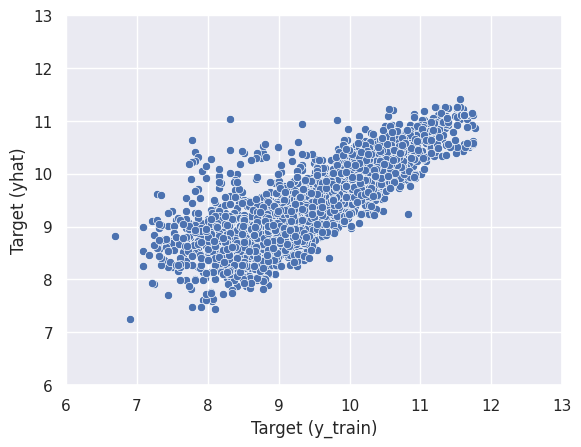

In [210]:
sns.scatterplot(x = y_train, y = yhat)
plt.xlabel("Target (y_train)")
plt.ylabel("Target (yhat)")
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

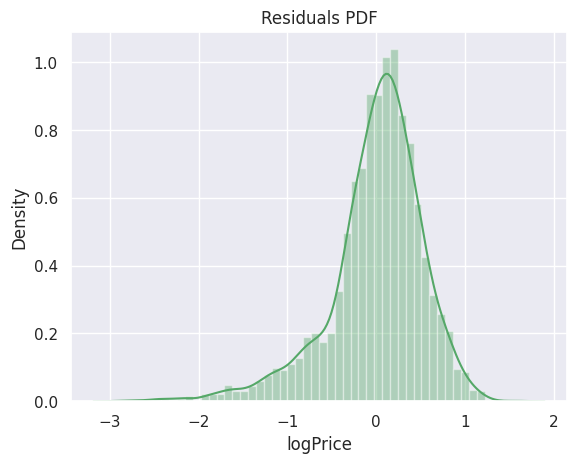

In [211]:
sns.distplot(y_train - yhat, color='g')
plt.title('Residuals PDF')
plt.show()

In [212]:
### Finding weights and bias
regSummary = pd.DataFrame(data = input.columns.values, columns=['Feature'])
regSummary['Weights'] = reg.coef_
regSummary

,Feature,Weights
0,Mileage,-0.533676
1,EngineV,0.225283
2,Brand_BMW,0.027765
3,Brand_Mercedes-Benz,0.053894
4,Brand_Mitsubishi,-0.116786
5,Brand_Renault,-0.133480
6,Brand_Toyota,-0.020039
7,Brand_Volkswagen,-0.046920
8,Body_hatch,-0.163031
9,Body_other,-0.101922


#### Testing

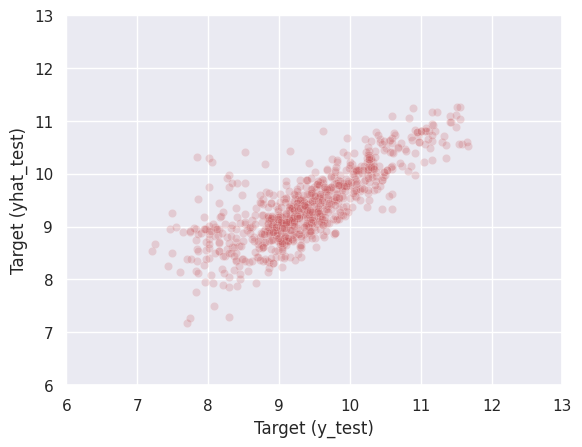

In [213]:
yhat_test = reg.predict(x_test)

sns.scatterplot(x = y_test, y = yhat_test, color='r', alpha = .2)
plt.xlabel("Target (y_test)")
plt.ylabel("Target (yhat_test)")
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [214]:
df_pf = pd.DataFrame(np.exp(yhat_test), columns=['Prediction'])
y_test = y_test.reset_index(drop = True) #avoid pandas to match the index
df_pf['ActualPrice'] = np.exp(y_test)
df_pf['Residual'] = (df_pf.ActualPrice - df_pf.Prediction).round(2)
df_pf['Difference %'] = (np.absolute(df_pf.Residual / df_pf.ActualPrice)*100).round(2)

In [215]:
df_pf

,Prediction,ActualPrice,Residual,Difference %
0,7032.832109,8200.0,1167.17,14.23
1,6334.347666,8200.0,1865.65,22.75
2,17147.302375,13200.0,-3947.30,29.90
3,2777.205397,3200.0,422.79,13.21
4,4537.280411,5950.0,1412.72,23.74
...,...,...,...,...
769,4347.874526,4800.0,452.13,9.42
770,8005.746585,7800.0,-205.75,2.64
771,17263.683713,15300.0,-1963.68,12.83
772,17722.191185,18700.0,977.81,5.23


In [216]:
df_pf['Difference %'].describe()

count     774.000000
mean       46.001253
std        82.563172
min         0.040000
25%        12.840000
50%        27.175000
75%        46.342500
max      1082.230000
Name: Difference %, dtype: float64